In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation
from dariah_topics import doclist

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_ = doclist.PathDocList(path_txt)
doclist_txt = doclist_.full_paths(as_str=True)
doclist_txt

['corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt',
 'corpus_txt/Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt/Doyle_TheSignoftheFour.txt',
 'corpus_txt/Howard_GodsoftheNorth.txt',
 'corpus_txt/Howard_SchadowsinZamboula.txt',
 'corpus_txt/Howard_ShadowsintheMoonlight.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Kipling_TheJungleBook.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt',
 'corpus_txt/Lovecraft_AttheMountainofMadness.txt',
 'corpus_txt/Lovecraft_TheShunnedHouse.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Poe_ThePurloinedLetter.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [4]:
doc_labels = doclist_.labels()
doc_labels

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth',
 'Howard_SchadowsinZamboula',
 'Howard_ShadowsintheMoonlight',
 'Howard_TheDevilinIron',
 'Kipling_TheEndofthePassage',
 'Kipling_TheJungleBook',
 'Kipling_ThyServantaDog',
 'Lovecraft_AttheMountainofMadness',
 'Lovecraft_TheShunnedHouse',
 'Poe_EurekaAProsePoem',
 'Poe_TheCaskofAmontillado',
 'Poe_TheMasqueoftheRedDeath',
 'Poe_ThePurloinedLetter']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [6]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id     
1      3188       12
       12831     731
       12192       5
       15534     160
       5406        1

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

In [12]:
corpus = MmCorpus('gensim_txt.mm')

In [13]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [14]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [15]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

In [16]:
len(features_to_be_removed)

75

In [17]:
pre.save_sparse_bow(sparse_bow_short, "gensim_txt")

In [18]:
mm = MmCorpus("gensim_txt.mm")

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [19]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [20]:
len(doc2bow_list)

17

In [21]:
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

In [22]:
model.get_document_topics(doc2bow_list[1])

[(0, 0.046786194719125609),
 (1, 0.24408169162788992),
 (3, 0.15087843753015243),
 (7, 0.086074831710968247),
 (11, 0.16972027629479935),
 (12, 0.017199495561963457),
 (13, 0.060820147277691437),
 (15, 0.19021187209861942),
 (18, 0.017397239170707832)]

In [23]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['abject',
 'analogous',
 'adamantine',
 'sinner',
 'watkins',
 'hare',
 'tumultuous',
 'larch',
 'truck',
 'linking']

In [24]:
#Topic probabilities - zum Testen der Funktion
topics = model.show_topics(num_topics = model.num_topics, formatted=False)
keywords = []

num_topics = model.num_topics
topics_df = pre.pd.DataFrame(index = range(num_topics), columns= range(10))

for topic, values in topics:
    keyword = [value[0] for value in values]
    topics_df.loc[topic] = keyword

topics_df

,0,1,2,3,4,5,6,7,8,9
0,down,fixtures,cent,romeo's,labyrinth,downstairs,in_equability,horseman,one-story,longitude
1,abject,analogous,adamantine,sinner,watkins,hare,tumultuous,larch,truck,linking
2,vistas,glorious,adorned,coolly,mortar-less,sternenschicht,consisted,saucer,washoe,eleven
3,coolly,biasing,disturbingly,surprises,drawer,assemblages,hear,dejected,zoology,population
4,hare,favorable,belgian,sinner,surprises,in_equability,establishment,mischievous,tumultuous,anecdote
5,mischievous,lessons,abject,anecdote,analogous,larch,population,strangler,watkins,favorable
6,disgracefully,hardiest,salvator,instructive,breaks,topographical,analogous,there,wir,hike
7,queerness,glorious,whoo,mischievous,prosaic,tunk-a,manor,anecdote,miskatonic's,in_equability
8,glorious,drawer,in_equability,coolly,favorable,blue-bearded,assemblages,hare,linking,powerful
9,analogous,lessons,truck,linking,abhorred,tumultuous,swings,two,channel,comprises


In [25]:
topics_df = pre.gensim2dataframe(model)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,down,fixtures,cent,romeo's,labyrinth,downstairs,in_equability,horseman,one-story,longitude
1,abject,analogous,adamantine,sinner,watkins,hare,tumultuous,larch,truck,linking
2,vistas,glorious,adorned,coolly,mortar-less,sternenschicht,consisted,saucer,washoe,eleven
3,coolly,biasing,disturbingly,surprises,drawer,assemblages,hear,dejected,zoology,population
4,hare,favorable,belgian,sinner,surprises,in_equability,establishment,mischievous,tumultuous,anecdote
5,mischievous,lessons,abject,anecdote,analogous,larch,population,strangler,watkins,favorable
6,disgracefully,hardiest,salvator,instructive,breaks,topographical,analogous,there,wir,hike
7,queerness,glorious,whoo,mischievous,prosaic,tunk-a,manor,anecdote,miskatonic's,in_equability
8,glorious,drawer,in_equability,coolly,favorable,blue-bearded,assemblages,hare,linking,powerful
9,analogous,lessons,truck,linking,abhorred,tumultuous,swings,two,channel,comprises


In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,down,abject,vistas,coolly,hare,mischievous,disgracefully,queerness,glorious,analogous,atlantis,coolly,flotilla,atlantis,deftly,strangler,fiendishness,spots,rochester,disturbingly
1,fixtures,analogous,glorious,biasing,favorable,lessons,hardiest,glorious,drawer,lessons,sinner,mortar-less,waked,awhile,schelmen,belgian,careful,companions,trouser,mischievous
2,cent,adamantine,adorned,disturbingly,belgian,abject,salvator,whoo,in_equability,truck,mischievous,disturbingly,settle,favorable,dissuading,anecdote,alarm,cloud,excellently,tumultuous
3,romeo's,sinner,coolly,surprises,sinner,anecdote,instructive,mischievous,coolly,linking,strangler,revenues,daughter's,smellest,nemedian,favorable,ssso,diving,the-wisps,strangler
4,labyrinth,watkins,mortar-less,drawer,surprises,analogous,breaks,prosaic,favorable,abhorred,favorable,stop,surprises,mischievous,illimitation,disturbingly,harangue,presupposes,coolly,favorable
5,downstairs,hare,sternenschicht,assemblages,in_equability,larch,topographical,tunk-a,blue-bearded,tumultuous,in_equability,snoring,parents,yellowstone,collect,establishment,downstairs,enchanted,watkins,belgian
6,in_equability,tumultuous,consisted,hear,establishment,population,analogous,manor,assemblages,swings,smellest,linking,tunk-a,sphereicity,scratch,glorious,hare,jean,suffer,sinner
7,horseman,larch,saucer,dejected,mischievous,strangler,there,anecdote,hare,two,establishment,boot-house,illumined,indirect,beefy,throned,pleistocene,persistence,mortar-less,channel
8,one-story,truck,washoe,zoology,tumultuous,watkins,wir,miskatonic's,linking,channel,anecdote,corked,unnoticed,swings,shove,ensued,visualized,creeps,leaders,in_equability
9,longitude,linking,eleven,population,anecdote,favorable,hike,in_equability,powerful,comprises,glorious,drawer,melon-bed,strangler,acceptance,zoology,establishment,magistrates,mischievous,establishment


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

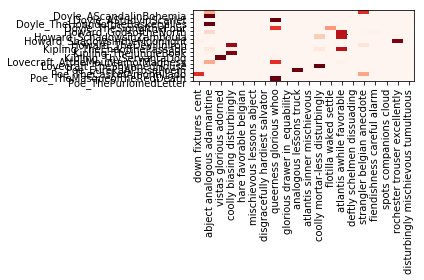

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

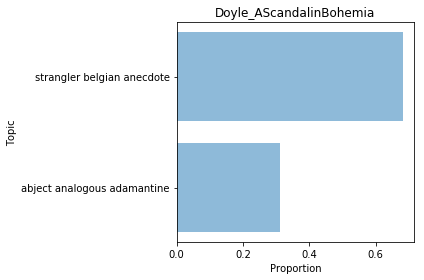

In [30]:
visual.plot_doc_topics(doc_topic, 0)

In [31]:
items = model.show_topic(1)
keywords = [item[0] for item in items]
keywords
items = model.show_topic(1)
propabilities = [item[1] for item in items]
propabilities
items

[('abject', 0.0071719609453676668),
 ('analogous', 0.0067440057486722518),
 ('adamantine', 0.00443200785312924),
 ('sinner', 0.0044201705151885222),
 ('watkins', 0.0039679605934900752),
 ('hare', 0.0038780072408505168),
 ('tumultuous', 0.0037443202026385828),
 ('larch', 0.0037218213278236178),
 ('truck', 0.0034780051542337301),
 ('linking', 0.0034627177126217942)]

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

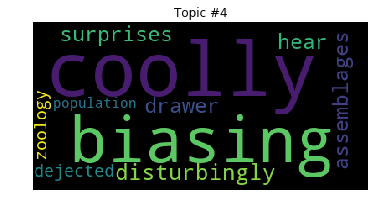

In [32]:
topic_nr = 3
number_of_keywords = 10
visual.show_wordle_for_topic(model, topic_nr, number_of_keywords)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)